# Importy

In [1]:
#!pip install opencv-python
#!pip install transformers
#!pip install umap-learn

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "5"

In [2]:
import numpy as np
import pandas as pd 
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 # KsztaÅ‚ty, kontury

# Do entropii
from skimage.color import rgb2gray
from skimage.measure import shannon_entropy

# Do ekstrakcji cech
from skimage.feature import graycomatrix, graycoprops
from skimage import util
from scipy import ndimage as ndi

# Do embedingu
from transformers import CLIPModel, CLIPProcessor
import torch

# Rzutowanie
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap

# Klasteryzacja
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score #Do sprawdzenia zgodnoÅ›ci z etykietami
from sklearn.preprocessing import LabelEncoder #GdyÅ¼ skalujÄ… siÄ™ teÅ¼ etykiety

## Wczytywanie obrazÃ³w do listy i sprawdzanie poprawnoÅ›ci

In [3]:
def validate_images(root_dir, expected_shape=(None, None, 3)):

    valid_images = []
    corrupted_files = []
    invalid_shapes = []
    
    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if not file.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue
                
            path = os.path.join(subdir, file)
            try:
                with Image.open(path) as img:
                    img = img.convert("RGB")
                    img_array = np.array(img)

                if expected_shape[0] is not None and img_array.shape[0] != expected_shape[0]:
                    raise ValueError(f"NieprawidÅ‚owa wysokoÅ›Ä‡: {img_array.shape[0]} (oczekiwano {expected_shape[0]})")
                if expected_shape[1] is not None and img_array.shape[1] != expected_shape[1]:
                    raise ValueError(f"NieprawidÅ‚owa szerokoÅ›Ä‡: {img_array.shape[1]} (oczekiwano {expected_shape[1]})")
                if expected_shape[2] is not None and img_array.shape[2] != expected_shape[2]:
                    raise ValueError(f"NieprawidÅ‚owa liczba kanaÅ‚Ã³w: {img_array.shape[2]} (oczekiwano {expected_shape[2]})")
                
                valid_images.append(img_array)
                
            except (UnidentifiedImageError, ValueError, OSError) as e:
                corrupted_files.append(path)
                print(f"Uszkodzony/nieprawidÅ‚owy plik: {path} | BÅ‚Ä…d: {str(e)}")
            except Exception as e:
                corrupted_files.append(path)
                print(f"Nieoczekiwany bÅ‚Ä…d w pliku {path}: {str(e)}")
    

    print(f"\nWynik walidacji:")
    print(f"Poprawne obrazy: {len(valid_images)}")
    print(f"Uszkodzone pliki: {len(corrupted_files)}")
    print(f"Obrazy z nieprawidÅ‚owym ksztaÅ‚tem: {len(invalid_shapes)}")
    
    return valid_images, corrupted_files, invalid_shapes


root_dir = "Pistachio_Image_Dataset"
expected_shape = (600, 600, 3)

images, corrupted_files, invalid_shapes = validate_images(root_dir, expected_shape)



Wynik walidacji:
Poprawne obrazy: 2148
Uszkodzone pliki: 0
Obrazy z nieprawidÅ‚owym ksztaÅ‚tem: 0


In [ ]:
images[0].shape

In [4]:
#Do sprawdzenia, jak dobrze nam podzieliÅ‚o
arr = np.concatenate([np.zeros(1232), np.ones(916)])
pistacje_df = pd.DataFrame({'pistacja': arr})

### WyÅ›wietlenie obrazÃ³w

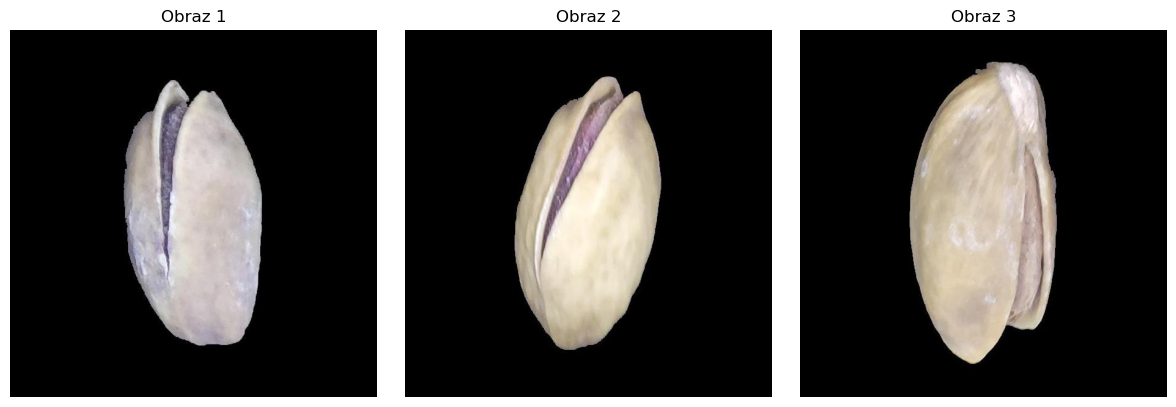

In [10]:
# WyÅ›wietlenie 3 pierwszych obrazÃ³w
plt.figure(figsize=(12, 4))

for i in range(3):
    plt.subplot(1, 3, i + 1)  
    plt.imshow(images[i])     
    plt.axis('off')          
    plt.title(f"Obraz {i + 1}")

plt.tight_layout()
plt.show()

# EDA

In [ ]:
def cechy_ksztaltu(img_array):
    gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
    
    _, binary = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)
    
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) > 0:
        contour = max(contours, key=cv2.contourArea)
        # Pole powierzchni (w pikselach)
        area = cv2.contourArea(contour)
        # ObwÃ³d obiektu
        perimeter = cv2.arcLength(contour, True)
        # ProstokÄ…t ograniczajÄ…cy (szerokoÅ›Ä‡ i wysokoÅ›Ä‡)
        x, y, width, height = cv2.boundingRect(contour)
        circularity = 4 * np.pi * area / (perimeter ** 2)
        aspect_ratio = float(width) / height
    else:
        area = 0
        perimeter = 0
        width = 0
        height = 0
        circularity = 0
        aspect_ratio = 0

    # Zwracamy sÅ‚ownik z cechami
    return {
        "area": area,
        "perimeter": perimeter,
        "width": width,
        "height": height,
        "circularity": circularity,
        "aspect_ratio": aspect_ratio
    }



In [ ]:
features = []

for i, img_array in enumerate(images):
    # Konwersja do skali szaroÅ›ci
    gray = np.mean(img_array, axis=2)  # Åšrednia z RGB kanaÅ‚Ã³w

    avg_gray = np.mean(gray)
    contrast = np.max(gray) - np.min(gray)

    # HSV: nasycenie i jasnoÅ›Ä‡
    hsv = cv2.cvtColor(img_array, cv2.COLOR_RGB2HSV)
    s_mean = np.mean(hsv[:, :, 1])  # Saturacja
    v_mean = np.mean(hsv[:, :, 2])  # JasnoÅ›Ä‡


    ksztalt = cechy_ksztaltu(img_array)
    features.append({
        "Obraz": f"Obraz {i+1}",
        "Åšredni odcieÅ„ szaroÅ›ci": round(avg_gray, 2),
        "Kontrast": round(contrast, 2),
        "r_mean": np.mean(img_array[:, :, 0]), 
        "g_mean": np.mean(img_array[:, :, 1]),  
        "b_mean": np.mean(img_array[:, :, 2]),
        "r_std": np.std(img_array[:, :, 0]),
        "g_std": np.std(img_array[:, :, 1]),
        "b_std": np.std(img_array[:, :, 2]),
        "area": ksztalt["area"],
        "perimeter": ksztalt["perimeter"],
        "width": ksztalt["width"],
        "height": ksztalt["height"],
        "aspect_ratio": ksztalt["aspect_ratio"],
        "circularity": ksztalt["circularity"],
        "saturation_mean": round(s_mean, 2),
        "brightness_mean": round(v_mean, 2)
    })


df = pd.DataFrame(features)

print(df)

## Wykresy

In [ ]:
sns.histplot(df["Kontrast"], bins=30, kde=True)
plt.title("RozkÅ‚ad kontrastu w obrazach")
plt.xlabel("Kontrast")
plt.ylabel("Liczba obrazÃ³w")
plt.show()

In [ ]:
sns.boxplot(data=df[["r_mean", "g_mean", "b_mean"]], palette=["red", "green", "blue"])
plt.title("RozkÅ‚ad Å›rednich wartoÅ›ci RGB")
plt.ylabel("Åšrednia wartoÅ›Ä‡ kanaÅ‚u")
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))

# Histogramy z kernel density estimate (KDE)
sns.histplot(df["r_mean"], color='red', kde=True, label='R (Red)', stat='density', bins=30, alpha=0.25)
sns.histplot(df["g_mean"], color='green', kde=True, label='G (Green)', stat='density', bins=30, alpha=0.25)
sns.histplot(df["b_mean"], color='blue', kde=True, label='B (Blue)', stat='density', bins=30, alpha=0.25)

plt.title("RozkÅ‚ad Å›rednich wartoÅ›ci kanaÅ‚Ã³w RGB (na obraz)")
plt.xlabel("Åšrednia wartoÅ›Ä‡ kanaÅ‚u (0â€“255)")
plt.ylabel("GÄ™stoÅ›Ä‡")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:

sns.histplot(df["brightness_mean"], bins=30, kde=True)
plt.title("RozkÅ‚ad jasnoÅ›ci w obrazach")
plt.xlabel("JasnoÅ›Ä‡")
plt.ylabel("Liczba obrazÃ³w")
plt.show()

In [ ]:
sns.histplot(df["saturation_mean"], bins=50, kde=True)
plt.title("RozkÅ‚ad saturacji w obrazach")
plt.xlabel("Saturacja")
plt.ylabel("Liczba obrazÃ³w")
plt.show()

In [ ]:
sns.histplot(df["width"], bins=50, label="SzerokoÅ›Ä‡", kde=True)
sns.histplot(df["height"], bins=50, label="DÅ‚ugoÅ›Ä‡", kde=True)
plt.title("RozkÅ‚ad szerokoÅ›ci i dÅ‚ugoÅ›ci pistacji")
plt.xlabel("WartoÅ›Ä‡ w pixelach")
plt.ylabel("Liczba obrazÃ³w")
plt.legend()
plt.show()

SzerokoÅ›Ä‡ jest lewoskoÅ›na, dÅ‚ugoÅ›Ä‡ prawoskoÅ›na.

In [ ]:
sns.histplot(df["aspect_ratio"], bins=50, label="WydÅ‚uÅ¼enie", kde=True)
sns.histplot(df["circularity"], bins=50, label="ZaokrÄ…glrnie", kde=True)
plt.title("RozkÅ‚ad wydÅ‚uÅ¼enia i zaokrÄ…glenia pistacji")
plt.xlabel("WartoÅ›Ä‡ w pixelach")
plt.ylabel("Liczba obrazÃ³w")
plt.legend()
plt.show()

In [ ]:
sns.histplot(df["perimeter"], bins=50, kde=True)
plt.title("ObwÃ³d pistacji")
plt.xlabel("WartoÅ›Ä‡ w pixelach")
plt.ylabel("Liczba obrazÃ³w")
plt.show()

In [ ]:
sns.histplot(df["area"], bins=50, kde=True)
plt.title("Pole pistacji")
plt.xlabel("WartoÅ›Ä‡ w pixelach")
plt.ylabel("Liczba obrazÃ³w")
plt.show()

# Przetwarzanie obrazÃ³w

Dla obrazÃ³w: np. zmiana rozmiaru i standaryzacja obrazÃ³w, skala szaroÅ›ci, augmentacja danych (odbicie lustrzane, rotacja, przyciÄ™cie,
jasnoÅ›Ä‡), ekstrakcja cech (Haralick, Gabor), entropia, zanurzenia (CLIP, ViT, ResNet), inne

### PrzyciÄ™cie obrazÃ³w

In [ ]:
# obraz zmniejszony, aby byÅ‚o mniej czarnego tÅ‚a, nie ucina pistacji, bo wysokoÅ›Ä‡ wiÄ™ksza od max z height
images_np = np.array(images)

def crop_center(images, crop_size=540):
    h, w = images.shape[1:3]
    start_h = (h - crop_size) // 2
    start_w = (w - crop_size) // 2
    return images[:, start_h:start_h+crop_size, start_w:start_w+crop_size, :]

images_cropped = crop_center(images_np)


In [ ]:
# WyÅ›wietlenie 3 pierwszych obrazÃ³w
plt.figure(figsize=(12, 4))

for i in range(3):
    plt.subplot(1, 3, i + 1)  
    plt.imshow(images_cropped[i])     
    plt.axis('off')          
    plt.title(f"Obraz {i + 1}")

plt.tight_layout()
plt.show()

In [ ]:
images_cropped[0].shape

### Obliczenie entropii

- niska entropia - obszary jednorodne, gÅ‚adkie
- wysoka entropia - obszare bogate w detale i zmiennoÅ›Ä‡

- skala entropii w naszym wypadku wynosi od 0 do 8.

In [ ]:
def calculate_entropy(image):
    image = rgb2gray(image)
    return shannon_entropy(image)

entropy_values = [calculate_entropy(img) for img in images_cropped]

df['entropy'] = entropy_values

df.head(5)

## Ekstrakcja cech Haralicka i Gabora

Funkcja do ekstrakcji wybranych cech Harlicka z obrazu, wÅ‚aÅ›ciwie to z GLCM (macierzy wspÃ³Å‚wystÄ™powania).
Sprawdzane jest 6 cech (properties), zwiÄ…zane ze strukturÄ… obiektÃ³w na zdjÄ™ciu. Ich opis: https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.graycoprops

In [ ]:
def extract_haralick_features(image):
    # Konwersja do skali szaroÅ›ci
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image
        
    # Normalizacja wartoÅ›ci pikseli do zakresu [0, 255]
    if gray.dtype != np.uint8:
        gray = util.img_as_ubyte(gray)
    
    # Redukcja liczby poziomÃ³w szaroÅ›ci do 32 (przyspiesza obliczenia)
    gray = (gray / 8).astype(np.uint8)
    
    # Obliczenie macierzy GLCM dla czterech kierunkÃ³w i odlegÅ‚oÅ›ci 1
    distances = [1]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # 0Â°, 45Â°, 90Â°, 135Â°
    glcm = graycomatrix(gray, distances, angles, levels=32, symmetric=True, normed=True)
    
    # Obliczenie wÅ‚aÅ›ciwoÅ›ci GLCM (cech Haralicka)
    features = {}
    properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
    
    for prop in properties:
        feature_values = graycoprops(glcm, prop).flatten()
        # Dla kaÅ¼dej wÅ‚aÅ›ciwoÅ›ci zapisujemy Å›redniÄ… i odchylenie standardowe z czterech kierunkÃ³w
        features[f'haralick_{prop}_mean'] = np.mean(feature_values)
        features[f'haralick_{prop}_std'] = np.std(feature_values)
    
    return features

Funkcja do stworzenia jÄ…dra dla filtra Gabora, moÅ¼na podawaÄ‡ rÃ³Å¼ne wartoÅ›ci wpsÃ³Å‚czynnikÃ³w, co pomoÅ¼e znaleÅºÄ‡ odpowiednie wartoÅ›ci.

In [ ]:
def gabor_kernel(sigma, theta, lambd, gamma, psi):
    """
    Tworzy jÄ…dro filtru Gabora.
    
    Parametry:
    sigma (float): Odchylenie standardowe funkcji Gaussa
    theta (float): Orientacja filtru w radianach
    lambd (float): DÅ‚ugoÅ›Ä‡ fali funkcji sinusoidalnej
    gamma (float): WspÃ³Å‚czynnik ksztaÅ‚tu przestrzennego (stosunek wysokoÅ›ci do szerokoÅ›ci)
    psi (float): PrzesuniÄ™cie fazowe
    
    Zwraca:
    numpy.ndarray: JÄ…dro filtru Gabora
    """
    # Rozmiar jÄ…dra zaleÅ¼y od sigma (wiÄ™ksze sigma = wiÄ™ksze jÄ…dro)
    sigma_x = sigma
    sigma_y = sigma / gamma
    
    # Rozmiar jÄ…dra jako wielokrotnoÅ›Ä‡ sigma
    nstds = 3
    c = np.cos(theta)
    s = np.sin(theta)
    
    # Ustalamy rozmiar jÄ…dra
    xmax = max(abs(nstds * sigma_x * c), abs(nstds * sigma_y * s))
    ymax = max(abs(nstds * sigma_x * s), abs(nstds * sigma_y * c))
    xmax = np.ceil(max(1, xmax))
    ymax = np.ceil(max(1, ymax))
    
    # Tworzymy siatkÄ™ wspÃ³Å‚rzÄ™dnych
    y, x = np.mgrid[-ymax:ymax+1, -xmax:xmax+1]
    
    # ObrÃ³t wspÃ³Å‚rzÄ™dnych
    x_theta = x * c + y * s
    y_theta = -x * s + y * c
    
    # Oblienie jÄ…dra Gabora
    gb = np.exp(-.5 * (x_theta**2 / sigma_x**2 + y_theta**2 / sigma_y**2)) * np.cos(2 * np.pi * x_theta / lambd + psi)
    
    return gb

Funkcja do ekstrakcji cech Gabora z obrazu, zwiÄ…zane z ksztaÅ‚tem. 

In [ ]:
def extract_gabor_features(image, num_orientations= 4, num_scales=2):
    """
    Ekstrahuje cechy z filtru Gabora dla obrazu.
    
    Parametry:
    image (numpy.ndarray): Obraz wejÅ›ciowy
    num_orientations (int): Liczba orientacji filtrÃ³w
    num_scales (int): Liczba skal filtrÃ³w
    
    Zwraca:
    dict: SÅ‚ownik z cechami Gabora
    """
    # Konwersja do skali szaroÅ›ci, jeÅ›li obraz jest kolorowy
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image
    
    # Normalizacja wartoÅ›ci pikseli
    if gray.dtype != np.float64:
        gray = util.img_as_float(gray)
    
    # Parametry filtrÃ³w Gabora
    orientations = np.arange(num_orientations) * np.pi / num_orientations
    scales = [6, 12][:num_scales]  # DÅ‚ugoÅ›ci fal
    
    features = {}
    
    # Dla kaÅ¼dej skali i orientacji
    for i, lambd in enumerate(scales):
        for j, theta in enumerate(orientations):
            # Tworzymy filtr Gabora
            kernel = gabor_kernel(sigma=2.0, theta=theta, lambd=lambd, gamma=0.5, psi=0)
            
            # Filtrujemy obraz
            filtered_real = ndi.convolve(gray, kernel, mode='wrap')
            
            # WyodrÄ™bniamy cechy z odpowiedzi filtru
            features[f'gabor_mean_s{i}_o{j}'] = np.mean(filtered_real)
            features[f'gabor_var_s{i}_o{j}'] = np.var(filtered_real)
            features[f'gabor_energy_s{i}_o{j}'] = np.sum(filtered_real**2)
            # MoÅ¼na takÅ¼e dodaÄ‡ maksimum i minimÃ³w odpowiedzi filtru
            features[f'gabor_max_s{i}_o{j}'] = np.max(filtered_real)
            features[f'gabor_min_s{i}_o{j}'] = np.min(filtered_real)
    
    return features

PoniÅ¼sza funkcja ekstrahuje cechy obrazÃ³w Haralicka i Gabora i umieszcza w ramce danych

In [ ]:
def extract_features_from_image_array(images):
    all_features = []
    
    for i, img in enumerate(images):
        # Ekstrakcja cech
        features = {}
        features['image_index'] = i  # Zamiast Å›cieÅ¼ki uÅ¼ywamy indeksu
            
        # Cechy Haralicka
        haralick_features = extract_haralick_features(img)
        features.update(haralick_features)
            
        # Cechy Gabora
        gabor_features = extract_gabor_features(img)
        features.update(gabor_features)

        if (i+1) % 10 == 0:
                print(f"Przetworzono {i+1}/{len(images)} obrazÃ³w")
            
        all_features.append(features)
            
    
    features_df = pd.DataFrame(all_features)
    
    return features_df

In [ ]:
features_df = extract_features_from_image_array(images_cropped)

In [ ]:
features_df.head()

In [ ]:
features_df.to_csv("features_haralick_gabor_df.csv")

In [ ]:
df = pd.concat([df, features_df], axis=1)

In [ ]:
df.head(5)

In [ ]:
df.to_csv("df.csv")

In [ ]:
df.columns

## Embedding

### CLIP

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

#model = CLIPModel.from_pretrained("/kaggle/input/openaiclip-vit-base-patch32").to(device)
#processor = CLIPProcessor.from_pretrained("/kaggle/input/openaiclip-vit-base-patch32")

In [12]:
def get_clip_embedding(image):
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
    return image_features.cpu().numpy().flatten()


In [13]:
embedding_list = []

for img in images:
    embedding = get_clip_embedding(img)
    embedding_list.append(embedding)

import pandas as pd
embedding_df_clip = pd.DataFrame(embedding_list)


In [21]:
embedding_df_clip.head()

0         1         2         3         4         5         6  \
0  0.048033  0.459915  0.291236 -0.254376 -0.034790  0.133871  0.001176   
1  0.203043  0.374007  0.282877 -0.336280 -0.042541 -0.172310  0.021400   
2  0.265154  0.222612  0.068482 -0.379982 -0.109268 -0.004189  0.031808   
3  0.162041  0.335131  0.284274 -0.091042  0.072769 -0.139423  0.156120   
4 -0.191196  0.580006  0.496780 -0.277269 -0.136410  0.224824  0.103528   

          7         8         9  ...       502       503       504       505  \
0  0.691546  0.451908  0.205750  ...  0.273844  0.388250  0.026766 -0.609339   
1  0.686466  0.910495  0.214304  ...  0.276241  0.352443 -0.235547 -0.347015   
2  0.767921  0.595037  0.235484  ...  0.301613  0.349988 -0.224748 -0.270477   
3  0.641323  0.350794 -0.015559  ...  0.255998  0.561428 -0.093416 -0.557868   
4  0.725216  0.365372  0.106128  ...  0.092643  0.440547  0.096467 -0.459164   

        506       507       508       509       510       511  
0 -0.100074 -0.008771 -0.143133  0.464985  0.050347 -0.345772  
1 -0.206668  0.043180  0.109531  0.117164  0.175577 -0.175406  
2 -0.375917 -0.114024  0.043042  0.182118  0.288143 -0.200093  
3 -0.080351  0.020012 -0.170848  0.151557  0.127911 -0.361583  
4  0.034822 -0.034684 -0.062749  0.395038  0.363856 -0.245063  

[5 rows x 512 columns]

In [ ]:
#embedding_df_clip.to_csv("embedding_df_clip.csv")

### RESNET

In [2]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms

# Wybierz model ResNet (np. ResNet-50)
resnet = models.resnet50(pretrained=True)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])  # usuÅ„ warstwÄ™ klasyfikujÄ…cÄ…
resnet = resnet.to(device)
resnet.eval()

In [42]:

resnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # standardowe dla ImageNet
                         std=[0.229, 0.224, 0.225])
])

In [43]:
def get_resnet_embedding(image):
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)
    img_tensor = resnet_transform(image).unsqueeze(0).to(device)  # dodaj batch dim
    with torch.no_grad():
        features = resnet(img_tensor).squeeze()  # shape: (2048,)
    return features.cpu().numpy()

In [44]:
resnet_embeddings = []

for img in images:
    emb = get_resnet_embedding(img)
    resnet_embeddings.append(emb)

import pandas as pd
embedding_df_resnet = pd.DataFrame(resnet_embeddings)

In [45]:
embedding_df_resnet.head()

0         1         2         3         4         5         6     \
0  0.087562  0.423793  0.043374  0.000000  0.013118  0.559729  0.167542   
1  0.217342  0.555967  0.063219  0.000000  0.038040  0.271647  0.250964   
2  0.126597  0.212963  0.152286  0.142091  0.000000  1.071600  0.557448   
3  0.248108  0.664147  0.028012  0.000000  0.178059  1.093668  0.325655   
4  0.387103  0.755848  0.051783  0.015508  0.000963  0.458708  0.195404   

       7         8         9     ...      2038      2039      2040      2041  \
0  0.023685  0.795887  0.042016  ...  0.269204  0.986718  0.244816  0.256097   
1  0.126500  0.690025  0.061749  ...  0.095554  0.414796  0.320811  0.122843   
2  0.064552  0.680770  0.173500  ...  0.049407  0.726145  0.000084  0.150539   
3  0.064009  0.784643  0.102479  ...  0.409143  0.099153  0.004147  0.204355   
4  0.115873  0.428744  0.071730  ...  0.033806  0.287204  0.434914  0.095535   

       2042      2043      2044      2045      2046      2047  
0  0.706210  0.212287  0.034618  0.448561  1.296927  0.234171  
1  0.249653  0.174315  0.000850  0.459269  1.537813  0.474952  
2  0.358372  0.148358  0.046195  0.212429  1.931861  0.796206  
3  0.221411  0.184505  0.009090  0.062604  2.555662  1.015693  
4  0.195294  0.103803  0.015545  0.153125  1.549063  0.303355  

[5 rows x 2048 columns]

In [46]:
#embedding_df_resnet.to_csv("embedding_df_resnet.csv")

# Wczytanie wzystkich danych i podziaÅ‚.

Wszystkie tabele zawierajÄ… kolumnÄ™ "label", zwiÄ…zana jest ona z tym jaki rodzaj pistacji jest to w rzeczywistoÅ›ci. Przed trenowaniem naleÅ¼y usunÄ…Ä‡ tÄ™ kolumnÄ™, sÅ‚uÅ¼y ona tylko do ewentualnego sprawdzenia rezultatÃ³w.

ZwykÅ‚e dane

In [3]:
df = pd.read_csv("df.csv")

In [4]:
df = df.drop(columns = ['Unnamed: 0'])

In [5]:
df, df_valid = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)

In [6]:
#df_valid.to_csv("df_valid.csv")

In [7]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

CLIP

In [8]:
embedding_df_clip = pd.read_csv("embedding_df_clip.csv")

In [9]:
embedding_df_clip = embedding_df_clip.drop(columns = ['Unnamed: 0'])

In [10]:
embedding_df_clip, embedding_df_clip_valid = train_test_split(embedding_df_clip, test_size=0.3, stratify=embedding_df_clip['label'], random_state=42)

In [11]:
#embedding_df_clip_valid.to_csv("embedding_df_clip_valid.csv")

In [12]:
#all_mixed_df_clip = pd.concat([df, embedding_df_clip], axis=1)

In [13]:
scaler = StandardScaler()
embedding_df_clip_scaled = scaler.fit_transform(embedding_df_clip)
#all_mixed_df_scaled_clip = scaler.fit_transform(all_mixed_df_clip)

RESNET

In [14]:
embedding_df_resnet = pd.read_csv("embedding_df_resnet.csv")

In [15]:
embedding_df_resnet = embedding_df_resnet.drop(columns = ['Unnamed: 0'])

In [16]:
embedding_df_resnet, embedding_df_resnet_valid = train_test_split(embedding_df_resnet, test_size=0.3, stratify=embedding_df_resnet['label'], random_state=42)

In [17]:
#embedding_df_resnet_valid.to_csv("embedding_df_resnet_valid.csv")

In [18]:
#all_mixed_df_resnet = pd.concat([df, embedding_df_resnet], axis=1)

In [19]:
scaler = StandardScaler()
embedding_df_resnet_scaled = scaler.fit_transform(embedding_df_resnet)
#all_mixed_df_scaled_resnet = scaler.fit_transform(all_mixed_df_resnet)

# Zmniejszenie wymiarÃ³w

### Liczba cech

Sprawdzenie skumulowanej wariancji, ile cech wybraÄ‡. PoniÅ¼ej przedstawione jest tylko na ramce df_scaled, jednak wynik dla embedding_df_clip_scaled oraz embedding_df_resnet_scaled sÄ… podobne. Wybieramy 15 cech.

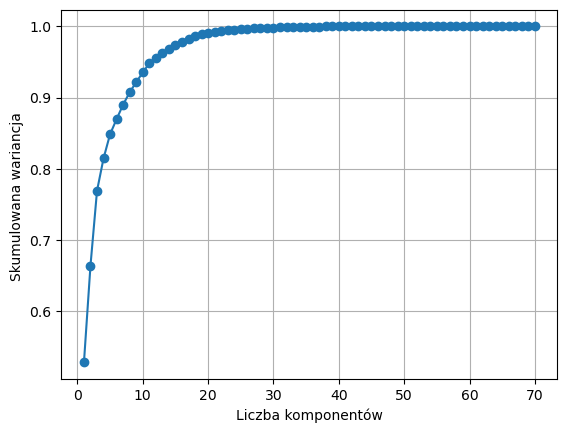

In [20]:
pca = PCA().fit(df_scaled[:, :-1])

explained_variance_ratio = pca.explained_variance_ratio_

cumulative_variance = np.cumsum(explained_variance_ratio)

plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Liczba komponentÃ³w')
plt.ylabel('Skumulowana wariancja ')

plt.grid(True)
plt.show()

### PCA

PCA: ZWYKLE, CLIP, RESNET

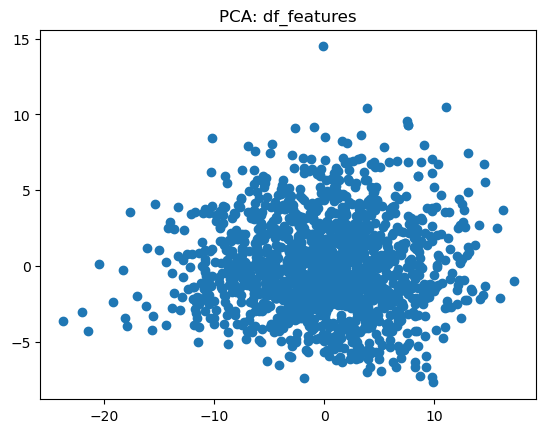

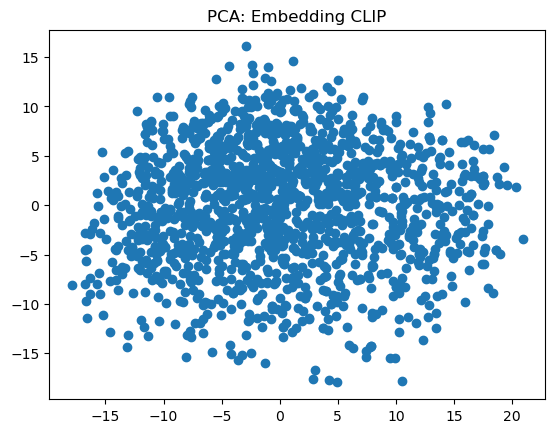

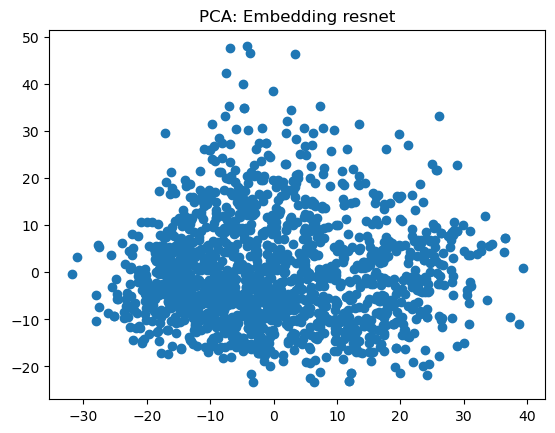

In [21]:
#PCA
pca = PCA(n_components=15)
df_pca = pca.fit_transform(df_scaled[:, :-1])

plt.scatter(df_pca[:, 0], df_pca[:, 1])
plt.title("PCA: df_features")
plt.show()

pca = PCA(n_components=15)
embedding_clip_pca = pca.fit_transform(embedding_df_clip_scaled[:, :-1])

plt.scatter(embedding_clip_pca[:, 0], embedding_clip_pca[:, 1])
plt.title("PCA: Embedding CLIP")
plt.show()

pca = PCA(n_components=15)
embedding_resnet_pca = pca.fit_transform(embedding_df_resnet_scaled[:, :-1])

plt.scatter(embedding_resnet_pca[:, 0], embedding_resnet_pca[:, 1])
plt.title("PCA: Embedding resnet")
plt.show()

# pca = PCA(n_components=2)
# all_mixed_df_clip_pca = pca.fit_transform(all_mixed_df_scaled_clip)

# plt.scatter(all_mixed_df_clip_pca[:, 0], all_mixed_df_clip_pca[:, 1])
# plt.title("PCA: mixed CLIP")
# plt.show()

# pca = PCA(n_components=2)
# all_mixed_df_resnet_pca = pca.fit_transform(all_mixed_df_scaled_resnet)

# plt.scatter(all_mixed_df_resnet_pca[:, 0], all_mixed_df_resnet_pca[:, 1])
# plt.title("PCA: mixed resnet")
# plt.show()

### TSNE

TSNE: ZWYKLE, CLIP, RESNET

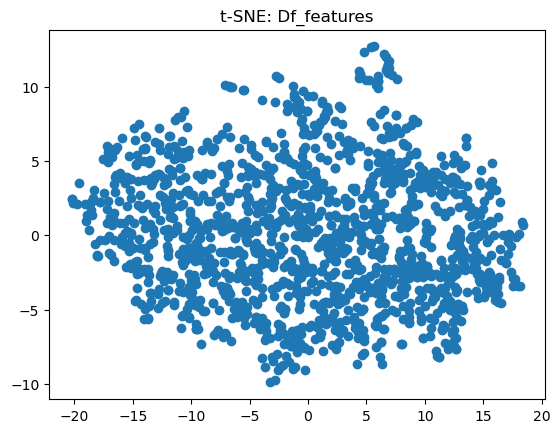

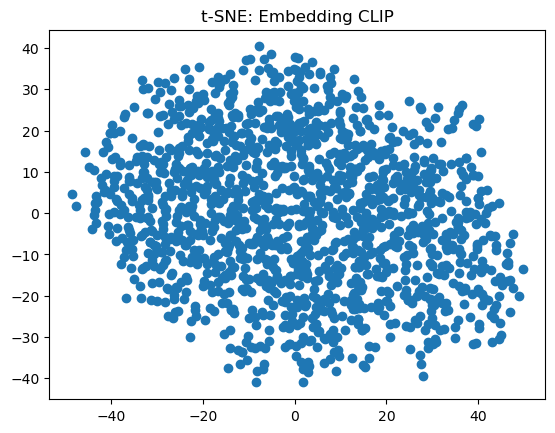

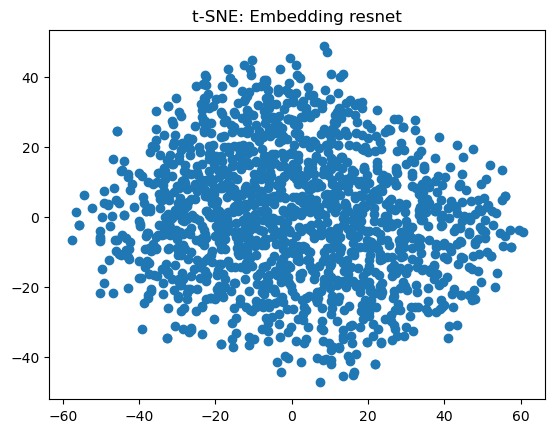

In [22]:
#TSNE
tsne = TSNE(n_components=3, random_state=42)
df_tsne = tsne.fit_transform(df_scaled[:,: -1])

plt.scatter(df_tsne[:, 0], df_tsne[:, 1])
plt.title('t-SNE: Df_features')
plt.show()

tsne = TSNE(n_components=3, random_state=42)
embedding_clip_tsne = tsne.fit_transform(embedding_df_clip_scaled[:, :-1])

plt.scatter(embedding_clip_tsne[:, 0], embedding_clip_tsne[:, 1])
plt.title('t-SNE: Embedding CLIP')
plt.show()

tsne = TSNE(n_components=3, random_state=42)
embedding_resnet_tsne = tsne.fit_transform(embedding_df_resnet_scaled[:,: -1])

plt.scatter(embedding_resnet_tsne[:, 0], embedding_resnet_tsne[:, 1])
plt.title('t-SNE: Embedding resnet')
plt.show()


# tsne = TSNE(n_components=2, random_state=42)
# all_mixed_df_clip_tsne = tsne.fit_transform(all_mixed_df_scaled_clip)

# plt.scatter(all_mixed_df_clip_tsne[:, 0], all_mixed_df_clip_tsne[:, 1])
# plt.title('t-SNE: mixed CLIP')
# plt.show()

# tsne = TSNE(n_components=2, random_state=42)
# all_mixed_df_resnet_tsne = tsne.fit_transform(all_mixed_df_scaled_resnet)

# plt.scatter(all_mixed_df_resnet_tsne[:, 0], all_mixed_df_resnet_tsne[:, 1])
# plt.title('t-SNE: mixed resnet')
# plt.show()

### UMAP

C:\Users\milek\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\milek\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


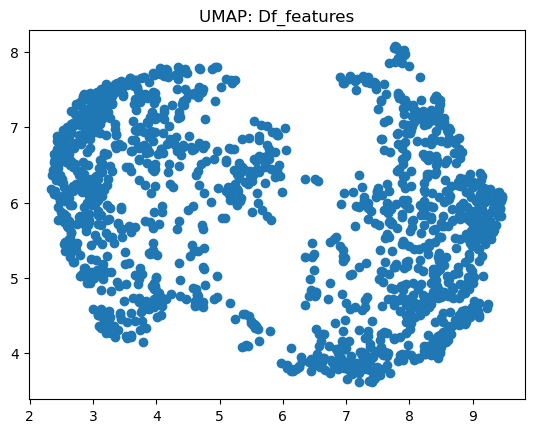

C:\Users\milek\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\milek\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


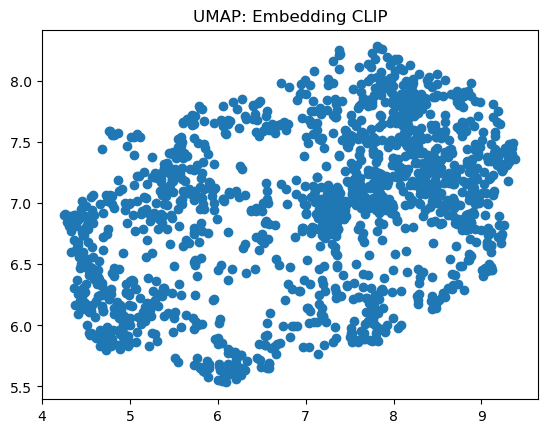

C:\Users\milek\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\milek\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


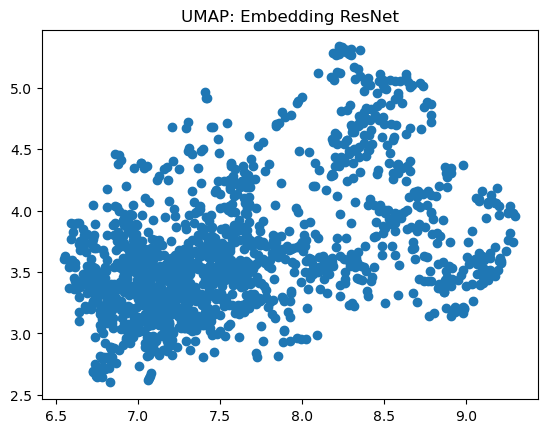

In [23]:
reducer = umap.UMAP(n_components=15, n_neighbors=10, min_dist=0.1, metric='cosine', random_state=42)
df_umap = reducer.fit_transform(df_scaled[:, :-1])

plt.scatter(df_umap[:, 0], df_umap[:, 1])
plt.title('UMAP: Df_features')
plt.show()

reducer = umap.UMAP(n_components=15, n_neighbors=10, min_dist=0.1, metric='cosine', random_state=42)
embedding_clip_umap = reducer.fit_transform(embedding_df_clip_scaled[:,: -1])

plt.scatter(embedding_clip_umap[:, 0], embedding_clip_umap[:, 1])
plt.title('UMAP: Embedding CLIP')
plt.show()

reducer = umap.UMAP(n_components=15, n_neighbors=10, min_dist=0.1, metric='cosine', random_state=42)
embedding_resnet_umap = reducer.fit_transform(embedding_df_resnet_scaled[:,: -1])

plt.scatter(embedding_resnet_umap[:, 0], embedding_resnet_umap[:, 1])
plt.title('UMAP: Embedding ResNet')
plt.show()


# reducer = umap.UMAP(n_components=2, random_state=42)
# all_mixed_df_clip_umap = reducer.fit_transform(all_mixed_df_scaled_clip)

# plt.scatter(all_mixed_df_clip_umap[:, 0], all_mixed_df_clip_umap[:, 1])
# plt.title('UMAP: Mixed CLIP')
# plt.show()

# --- UMAP: Mixed ResNet ---
# reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
# all_mixed_df_resnet_umap = reducer.fit_transform(all_mixed_df_scaled_resnet)

# plt.scatter(all_mixed_df_resnet_umap[:, 0], all_mixed_df_resnet_umap[:, 1])
# plt.title('UMAP: Mixed ResNet')
# plt.show()


In [24]:
print(len(embedding_df_resnet_scaled[0]))
print(len(df_scaled[0]))
print(len(embedding_df_clip_scaled[0]))

2049
71
513


# Klasteryzacja

## DBSCAN

Funkcja do trenowania DBSCAN, sprawdza dla rÃ³Åºnych wartoÅ›ci epsilon jakie sÄ… scory  

In [73]:
def evaluate_dbscan(X, y, eps_values, min_samples=5, metric='cosine'):
    sil_scores, ch_scores, db_scores = [], [], []
    ari_scores, nmi_scores = [], []
    n_clusters_list = []
    
    # zamiana label znowu na dyskretny, bo wczesniej byÅ‚ skalowany przez Scaler
    y = LabelEncoder().fit_transform(y)

    for eps in eps_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
        labels = dbscan.fit_predict(X)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_clusters_list.append(n_clusters)

        if n_clusters > 1:
            sil_scores.append(silhouette_score(X, labels))
            ch_scores.append(calinski_harabasz_score(X, labels))
            db_scores.append(davies_bouldin_score(X, labels))
            ari_scores.append(adjusted_rand_score(y, labels))
            nmi_scores.append(normalized_mutual_info_score(y, labels))
        else:
            sil_scores.append(np.nan)
            ch_scores.append(np.nan)
            db_scores.append(np.nan)
            ari_scores.append(np.nan)
            nmi_scores.append(np.nan)

    # Najlepsze wartoÅ›ci epsilon dla modeli
    sil_scores = np.array(sil_scores)
    ari_scores = np.array(ari_scores)
    
    best_eps_sil = eps_values[np.nanargmax(sil_scores)]
    best_eps_ari = eps_values[np.nanargmax(ari_scores)]

    print(f"ðŸ”¹ Najlepszy eps Silhouette Score: {best_eps_sil:.4f}")
    print(f"ðŸ”¹ Najlepszy eps Adjusted Rand Index: {best_eps_ari:.4f}")

    # Wykresy
    plt.figure(figsize=(18, 6))

    plt.subplot(2, 3, 1)
    plt.plot(eps_values, sil_scores, marker='o')
    plt.title('Silhouette Score')
    plt.xlabel('eps')

    plt.subplot(2, 3, 2)
    plt.plot(eps_values, ch_scores, marker='o', color='green')
    plt.title('Calinski-Harabasz Score')
    plt.xlabel('eps')

    plt.subplot(2, 3, 3)
    plt.plot(eps_values, db_scores, marker='o', color='red')
    plt.title('Davies-Bouldin Score')
    plt.xlabel('eps')

    plt.subplot(2, 3, 4)
    plt.plot(eps_values, ari_scores, marker='o', color='blue')
    plt.title('Adjusted Rand Index')
    plt.xlabel('eps')

    plt.subplot(2, 3, 5)
    plt.plot(eps_values, nmi_scores, marker='o', color='orange')
    plt.title('Normalized Mutual Info')
    plt.xlabel('eps')

    plt.subplot(2, 3, 6)
    plt.plot(eps_values, n_clusters_list, marker='o', color='purple')
    plt.title('Liczba klastrÃ³w')
    plt.xlabel('eps')

    plt.tight_layout()
    plt.show()
    
    return best_eps_sil, best_eps_ari


ðŸ”¹ Najlepszy eps Silhouette Score: 0.1289
ðŸ”¹ Najlepszy eps Adjusted Rand Index: 0.1421


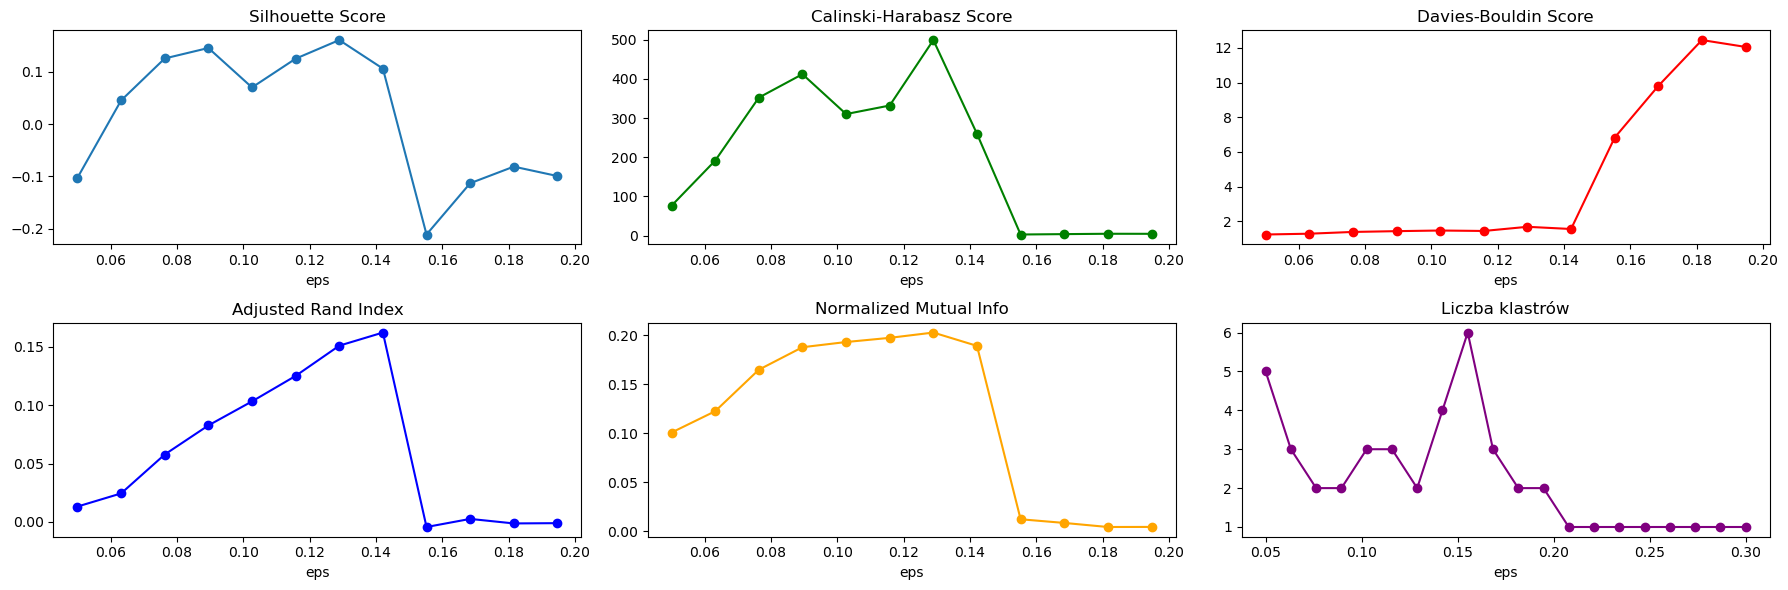

In [74]:
 best_sil, best_ari = evaluate_dbscan(X=df_scaled[:, :-1],
                          y=df_scaled[:, -1],
                          eps_values=np.linspace(0.05, 0.3, 20))

CLIP i RESNET majÄ… zbyt wiele wymiarÃ³w, dlatego puszczone zostaÅ‚y na pca (moÅ¼na dodaÄ‡ inne)

ðŸ”¹ Najlepszy eps Silhouette Score: 0.2342
ðŸ”¹ Najlepszy eps Adjusted Rand Index: 0.1816


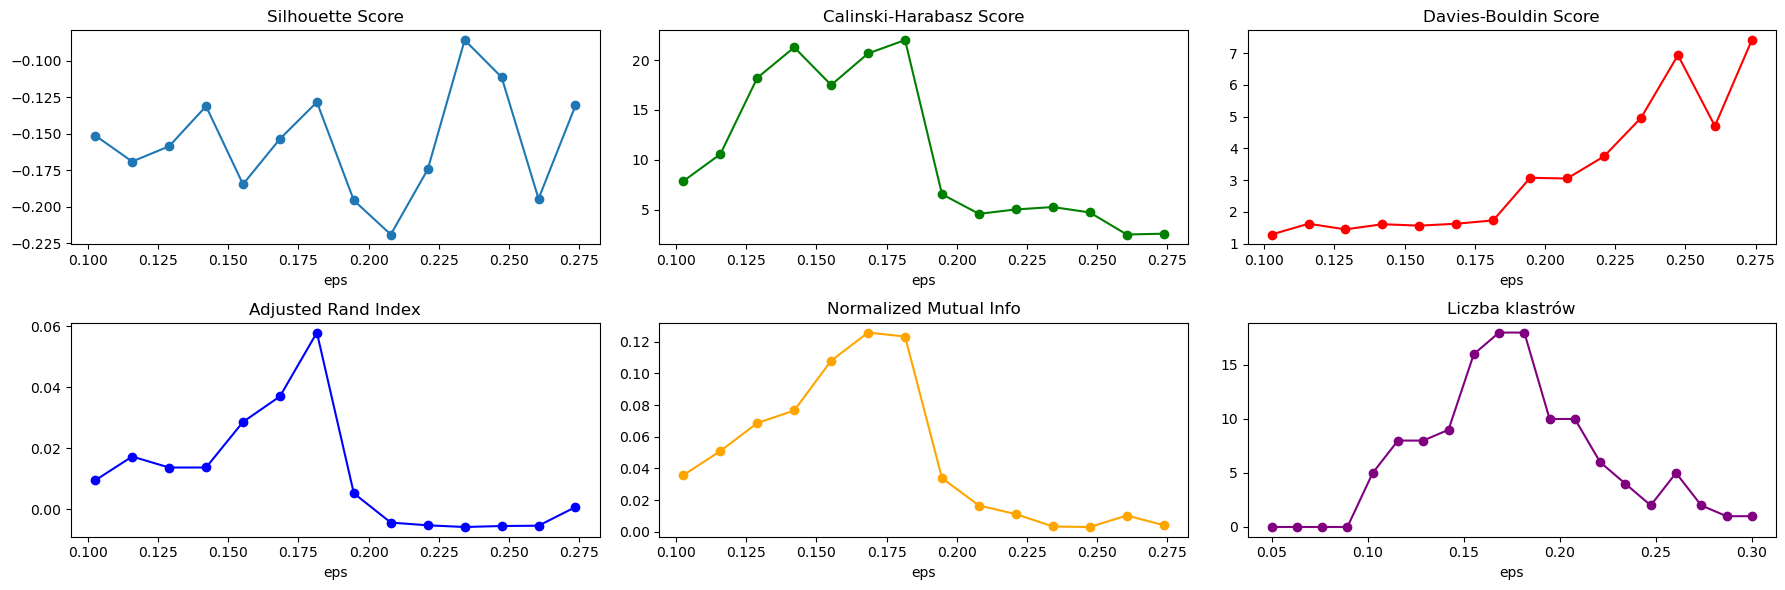

In [76]:
 best_sil, best_ari = evaluate_dbscan(X=embedding_clip_pca[:, :-1],
                          y=embedding_df_clip_scaled[:, -1],
                          eps_values=np.linspace(0.05, 0.3, 20))


ðŸ”¹ Najlepszy eps Silhouette Score: 0.1026
ðŸ”¹ Najlepszy eps Adjusted Rand Index: 0.1684


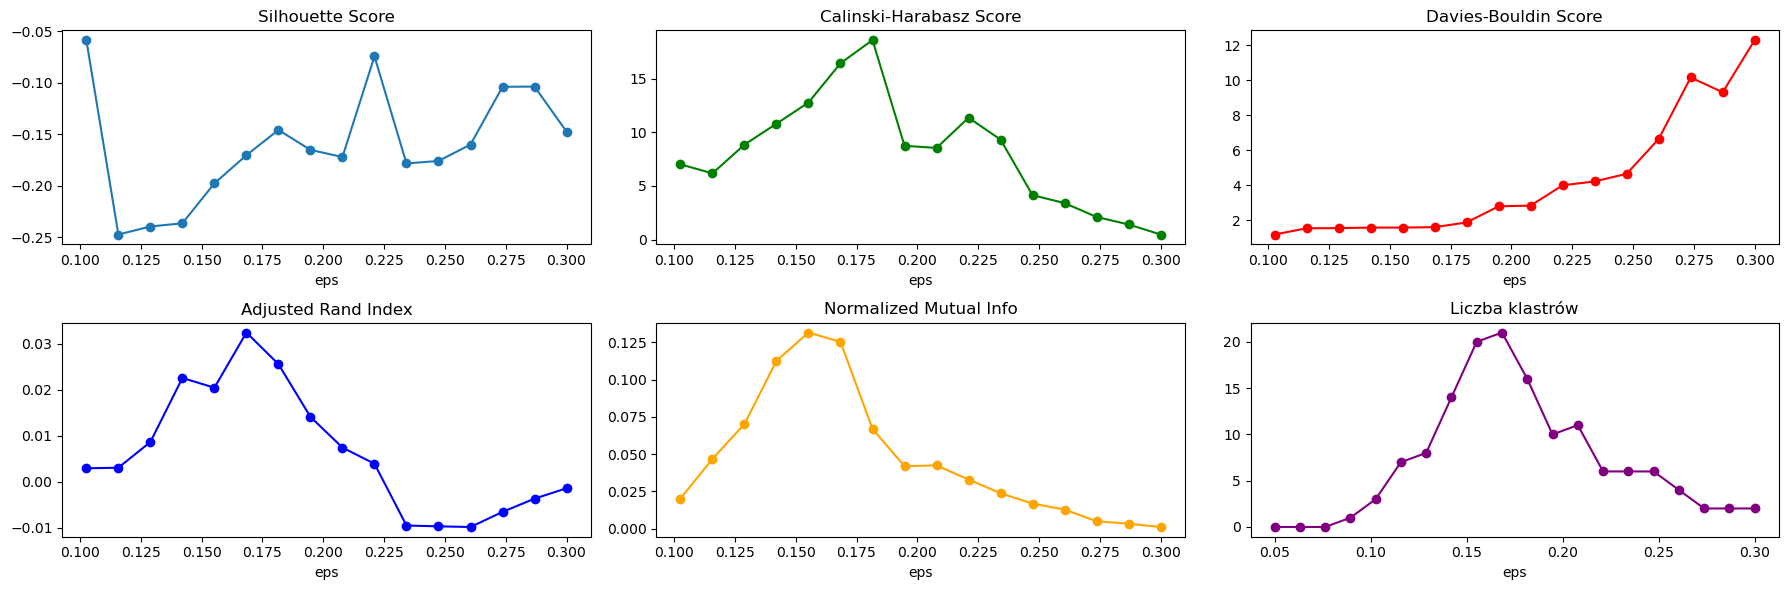

In [77]:
 best_sil, best_ari = evaluate_dbscan(X=embedding_resnet_pca[:, :-1],
                          y=embedding_df_resnet_scaled[:, -1],
                          eps_values=np.linspace(0.05, 0.3, 20))

In [ ]:
#DBSCAN
# dbscan = DBSCAN(eps=0.1421, min_samples=5, metric = 'cosine')
# labels_dbscan_resnet = dbscan.fit_predict(embedding_df_resnet_scaled[:, :-1])

# print("Silhouette:", silhouette_score(embedding_df_resnet_scaled[:, :-1], labels_dbscan_resnet))
# print("Calinski-Harabasz:", calinski_harabasz_score(embedding_df_resnet_scaled[:, :-1], labels_dbscan_resnet))
# print("Davies-Bouldin:", davies_bouldin_score(embedding_df_resnet_scaled[:, :-1], labels_dbscan_resnet))

## K-means

Dla tego algorytmu jest za duÅ¼a liczba wymiarÃ³w, wiÄ™c trzeba to zmniejszyÄ‡ korzystajÄ…c z wczeÅ›niejszego zmniejszania wymiarÃ³w. PoniÅ¼ej funkcja pomagajÄ…ca zwizualizowaÄ‡ wyniki. 

In [36]:
def evaluate_kmeans(X, y=None, k_range=range(2, 15)):
    sil_scores = []
    ch_scores = []
    db_scores = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)

        sil_scores.append(silhouette_score(X, labels))
        ch_scores.append(calinski_harabasz_score(X, labels))
        db_scores.append(davies_bouldin_score(X, labels))

    best_k_sil = k_range[np.argmax(sil_scores)]
    best_k_ch = k_range[np.argmax(ch_scores)]
    best_k_db = k_range[np.argmin(db_scores)]  # niÅ¼szy = lepszy

    print(f"ðŸ”¹ Najlepsze k wg Silhouette Score: {best_k_sil}")
    print(f"ðŸ”¹ Najlepsze k wg Calinski-Harabasz: {best_k_ch}")
    print(f"ðŸ”¹ Najlepsze k wg Davies-Bouldin: {best_k_db}")

    # Wykresy
    plt.figure(figsize=(15, 4))

    plt.subplot(1, 3, 1)
    plt.plot(k_range, sil_scores, marker='o')
    plt.title("Silhouette Score")
    plt.xlabel("Liczba klastrÃ³w (k)")

    plt.subplot(1, 3, 2)
    plt.plot(k_range, ch_scores, marker='o', color='green')
    plt.title("Calinski-Harabasz Score")
    plt.xlabel("Liczba klastrÃ³w (k)")

    plt.subplot(1, 3, 3)
    plt.plot(k_range, db_scores, marker='o', color='red')
    plt.title("Davies-Bouldin Score")
    plt.xlabel("Liczba klastrÃ³w (k)")

    plt.tight_layout()
    plt.show()

    return best_k_sil


### Bez zmniejszania wymiarÃ³w

ðŸ”¹ Najlepsze k wg Silhouette Score: 2
ðŸ”¹ Najlepsze k wg Calinski-Harabasz: 2
ðŸ”¹ Najlepsze k wg Davies-Bouldin: 2


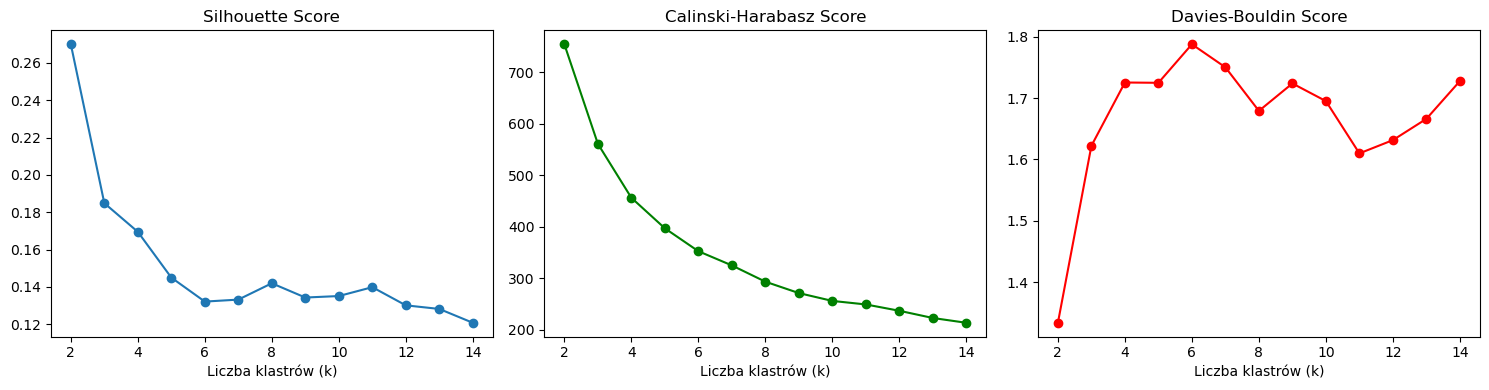

ARI: 0.2320
NMI: 0.1979


In [37]:
best_k = evaluate_kmeans(df_scaled[:, :-1], k_range=range(2, 15))

# Trening koÅ„cowego modelu
kmeans = KMeans(n_clusters=best_k, random_state=42)
labels_kmeans = kmeans.fit_predict(df_scaled[:, :-1])

y_encoded = LabelEncoder().fit_transform(df_scaled[:, -1])

ari = adjusted_rand_score(y_encoded, labels_kmeans)
nmi = normalized_mutual_info_score(y_encoded, labels_kmeans)

print(f"ARI: {ari:.4f}")
print(f"NMI: {nmi:.4f}")

ðŸ”¹ Najlepsze k wg Silhouette Score: 2
ðŸ”¹ Najlepsze k wg Calinski-Harabasz: 2
ðŸ”¹ Najlepsze k wg Davies-Bouldin: 10


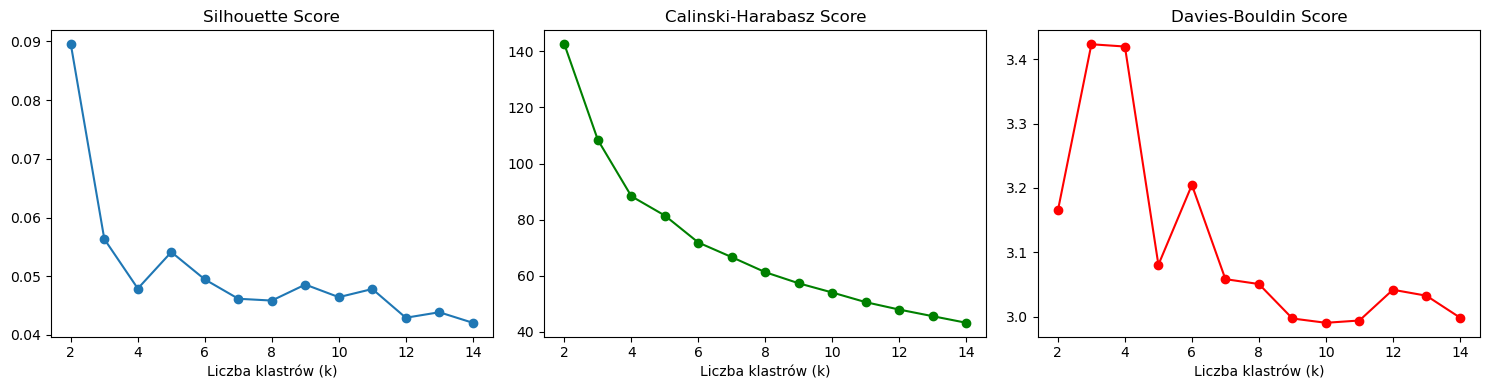

ARI: 0.1170
NMI: 0.0785


In [38]:
best_k = evaluate_kmeans(embedding_df_clip_scaled[:, :-1], k_range=range(2, 15))

# Trening koÅ„cowego modelu
kmeans = KMeans(n_clusters=best_k, random_state=42)
labels_kmeans = kmeans.fit_predict(embedding_df_clip_scaled[:, :-1])

y_encoded = LabelEncoder().fit_transform(embedding_df_clip_scaled[:, -1])

ari = adjusted_rand_score(y_encoded, labels_kmeans)
nmi = normalized_mutual_info_score(y_encoded, labels_kmeans)

print(f"ARI: {ari:.4f}")
print(f"NMI: {nmi:.4f}")

ðŸ”¹ Najlepsze k wg Silhouette Score: 2
ðŸ”¹ Najlepsze k wg Calinski-Harabasz: 2
ðŸ”¹ Najlepsze k wg Davies-Bouldin: 14


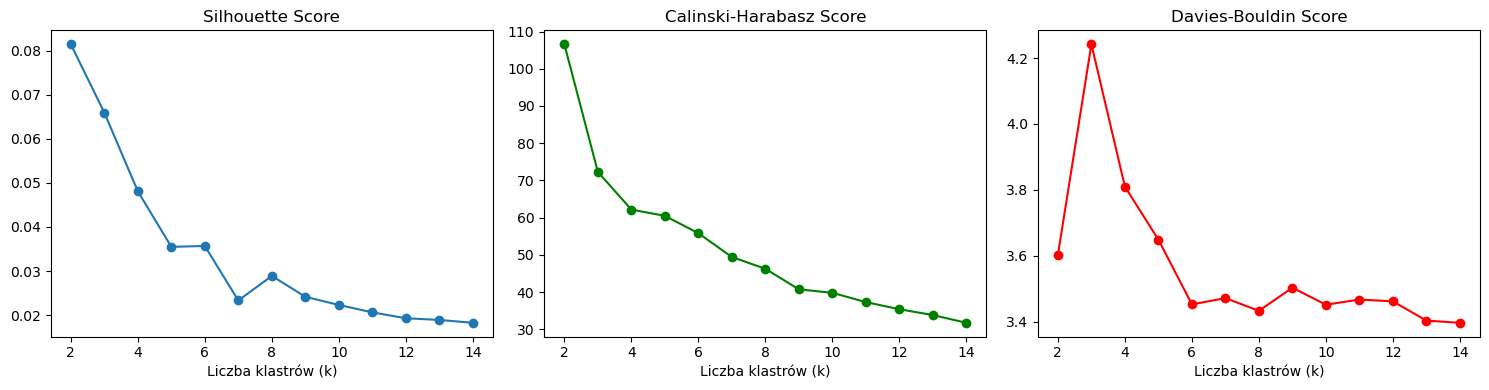

ARI: 0.0515
NMI: 0.0306


In [39]:
best_k = evaluate_kmeans(embedding_df_resnet_scaled[:, :-1], k_range=range(2, 15))

# Trening koÅ„cowego modelu
kmeans = KMeans(n_clusters=best_k, random_state=42)
labels_kmeans = kmeans.fit_predict(embedding_df_resnet_scaled[:, :-1])

y_encoded = LabelEncoder().fit_transform(embedding_df_resnet_scaled[:, -1])

ari = adjusted_rand_score(y_encoded, labels_kmeans)
nmi = normalized_mutual_info_score(y_encoded, labels_kmeans)

print(f"ARI: {ari:.4f}")
print(f"NMI: {nmi:.4f}")

### PCA

ðŸ”¹ Najlepsze k wg Silhouette Score: 2
ðŸ”¹ Najlepsze k wg Calinski-Harabasz: 2
ðŸ”¹ Najlepsze k wg Davies-Bouldin: 2


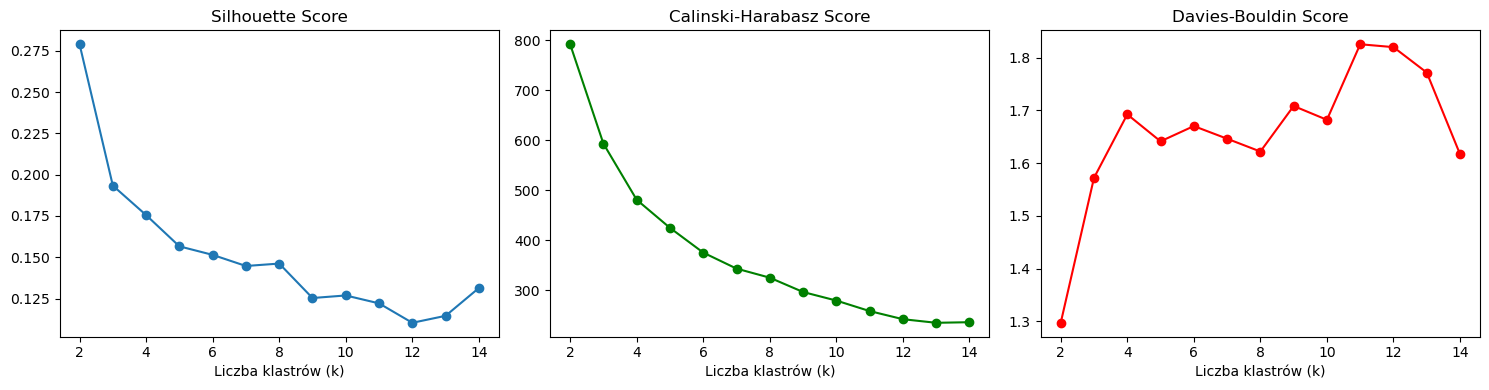

ARI: 0.2308
NMI: 0.1971


In [40]:
best_k = evaluate_kmeans(df_pca[:, :-1], k_range=range(2, 15))

# Trening koÅ„cowego modelu
kmeans = KMeans(n_clusters=best_k, random_state=42)
labels_kmeans = kmeans.fit_predict(df_pca[:, :-1])

y_encoded = LabelEncoder().fit_transform(df_scaled[:, -1])

ari = adjusted_rand_score(y_encoded, labels_kmeans)
nmi = normalized_mutual_info_score(y_encoded, labels_kmeans)

print(f"ARI: {ari:.4f}")
print(f"NMI: {nmi:.4f}")

ðŸ”¹ Najlepsze k wg Silhouette Score: 2
ðŸ”¹ Najlepsze k wg Calinski-Harabasz: 2
ðŸ”¹ Najlepsze k wg Davies-Bouldin: 9


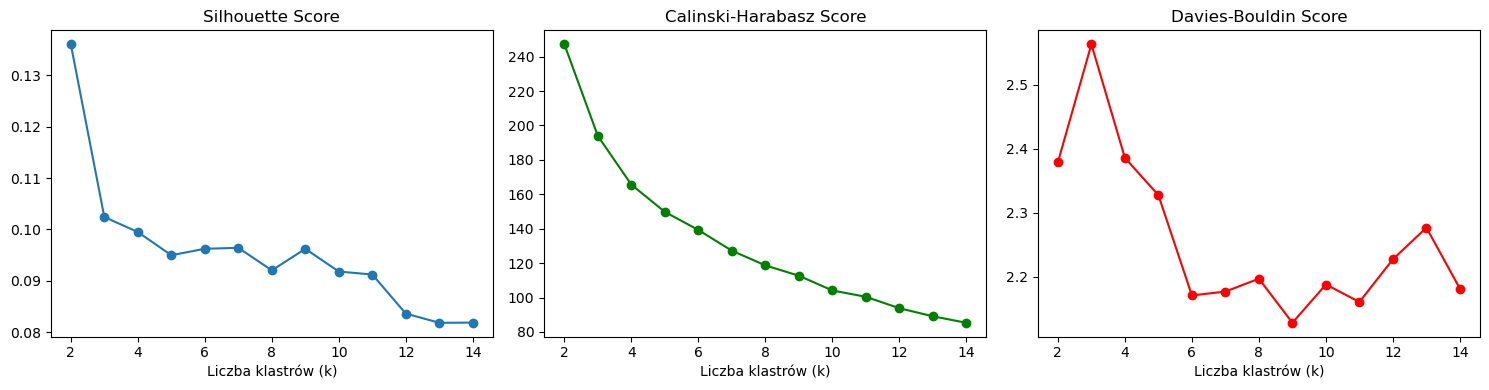

ARI: 0.1152
NMI: 0.0771


In [41]:
best_k = evaluate_kmeans(embedding_clip_pca[:, :-1], k_range=range(2, 15))

# Trening koÅ„cowego modelu
kmeans = KMeans(n_clusters=best_k, random_state=42)
labels_kmeans = kmeans.fit_predict(embedding_clip_pca[:, :-1])

y_encoded = LabelEncoder().fit_transform(embedding_df_clip_scaled[:, -1])
len(y_encoded)
ari = adjusted_rand_score(y_encoded, labels_kmeans)
nmi = normalized_mutual_info_score(y_encoded, labels_kmeans)

print(f"ARI: {ari:.4f}")
print(f"NMI: {nmi:.4f}")

ðŸ”¹ Najlepsze k wg Silhouette Score: 2
ðŸ”¹ Najlepsze k wg Calinski-Harabasz: 2
ðŸ”¹ Najlepsze k wg Davies-Bouldin: 14


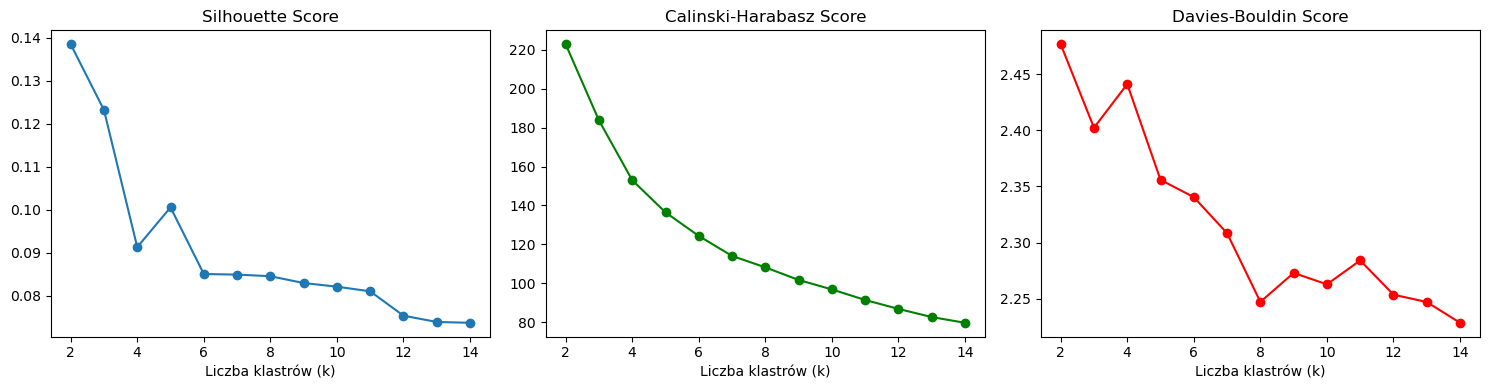

ARI: 0.0647
NMI: 0.0401


In [42]:
best_k = evaluate_kmeans(embedding_resnet_pca[:, :-1], k_range=range(2, 15))

# Trening koÅ„cowego modelu
kmeans = KMeans(n_clusters=best_k, random_state=42)
labels_kmeans = kmeans.fit_predict(embedding_resnet_pca[:, :-1])

y_encoded = LabelEncoder().fit_transform(embedding_df_resnet_scaled[:, -1])

ari = adjusted_rand_score(y_encoded, labels_kmeans)
nmi = normalized_mutual_info_score(y_encoded, labels_kmeans)

print(f"ARI: {ari:.4f}")
print(f"NMI: {nmi:.4f}")

### TSNE

ðŸ”¹ Najlepsze k wg Silhouette Score: 2
ðŸ”¹ Najlepsze k wg Calinski-Harabasz: 2
ðŸ”¹ Najlepsze k wg Davies-Bouldin: 2


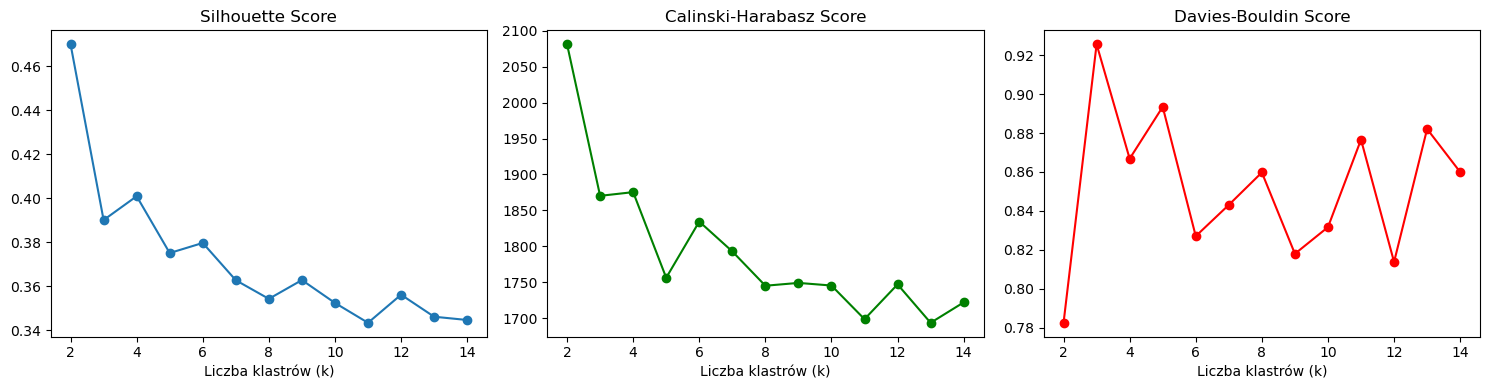

ARI: 0.2737
NMI: 0.2239


In [43]:
best_k = evaluate_kmeans(df_tsne[:, :-1], k_range=range(2, 15))

# Trening koÅ„cowego modelu
kmeans = KMeans(n_clusters=best_k, random_state=42)
labels_kmeans = kmeans.fit_predict(df_tsne[:, :-1])

y_encoded = LabelEncoder().fit_transform(df_scaled[:, -1])

ari = adjusted_rand_score(y_encoded, labels_kmeans)
nmi = normalized_mutual_info_score(y_encoded, labels_kmeans)

print(f"ARI: {ari:.4f}")
print(f"NMI: {nmi:.4f}")

ðŸ”¹ Najlepsze k wg Silhouette Score: 2
ðŸ”¹ Najlepsze k wg Calinski-Harabasz: 5
ðŸ”¹ Najlepsze k wg Davies-Bouldin: 11


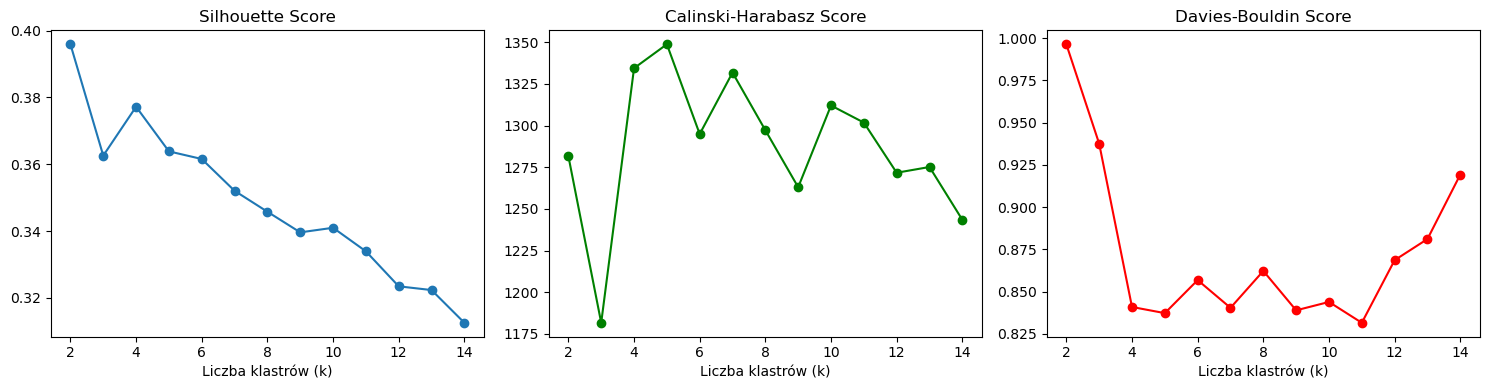

ARI: 0.0343
NMI: 0.0250


In [44]:
best_k = evaluate_kmeans(embedding_clip_tsne[:, :-1], k_range=range(2, 15))

# Trening koÅ„cowego modelu
kmeans = KMeans(n_clusters=best_k, random_state=42)
labels_kmeans = kmeans.fit_predict(embedding_clip_tsne[:, :-1])

y_encoded = LabelEncoder().fit_transform(embedding_df_clip_scaled[:, -1])

ari = adjusted_rand_score(y_encoded, labels_kmeans)
nmi = normalized_mutual_info_score(y_encoded, labels_kmeans)

print(f"ARI: {ari:.4f}")
print(f"NMI: {nmi:.4f}")

ðŸ”¹ Najlepsze k wg Silhouette Score: 2
ðŸ”¹ Najlepsze k wg Calinski-Harabasz: 4
ðŸ”¹ Najlepsze k wg Davies-Bouldin: 12


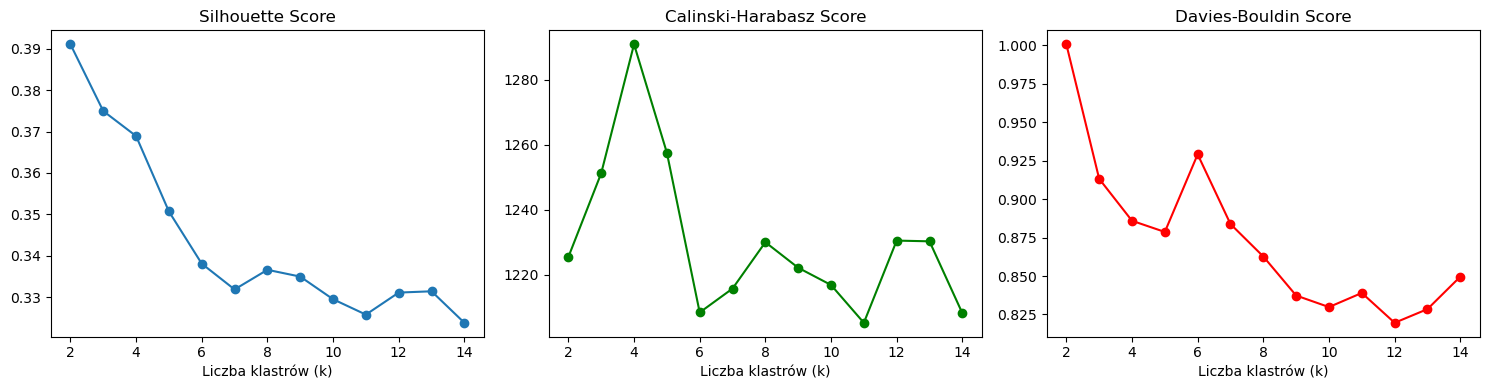

ARI: 0.0470
NMI: 0.0310


In [45]:
best_k = evaluate_kmeans(embedding_resnet_tsne[:, :-1], k_range=range(2, 15))

# Trening koÅ„cowego modelu
kmeans = KMeans(n_clusters=best_k, random_state=42)
labels_kmeans = kmeans.fit_predict(embedding_resnet_tsne[:, :-1])

y_encoded = LabelEncoder().fit_transform(embedding_df_resnet_scaled[:, -1])

ari = adjusted_rand_score(y_encoded, labels_kmeans)
nmi = normalized_mutual_info_score(y_encoded, labels_kmeans)

print(f"ARI: {ari:.4f}")
print(f"NMI: {nmi:.4f}")

### UMAP

ðŸ”¹ Najlepsze k wg Silhouette Score: 2
ðŸ”¹ Najlepsze k wg Calinski-Harabasz: 2
ðŸ”¹ Najlepsze k wg Davies-Bouldin: 2


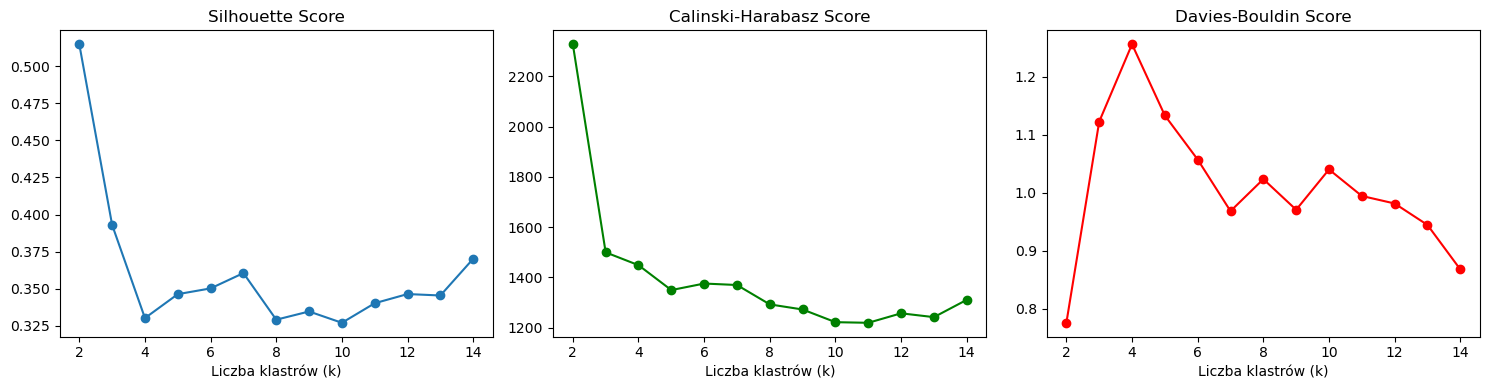

ARI: 0.2133
NMI: 0.1733


In [46]:
best_k = evaluate_kmeans(df_umap[:, :-1], k_range=range(2, 15))

# Trening koÅ„cowego modelu
kmeans = KMeans(n_clusters=best_k, random_state=42)
labels_kmeans = kmeans.fit_predict(df_umap[:, :-1])

y_encoded = LabelEncoder().fit_transform(df_scaled[:, -1])

ari = adjusted_rand_score(y_encoded, labels_kmeans)
nmi = normalized_mutual_info_score(y_encoded, labels_kmeans)

print(f"ARI: {ari:.4f}")
print(f"NMI: {nmi:.4f}")

ðŸ”¹ Najlepsze k wg Silhouette Score: 2
ðŸ”¹ Najlepsze k wg Calinski-Harabasz: 2
ðŸ”¹ Najlepsze k wg Davies-Bouldin: 2


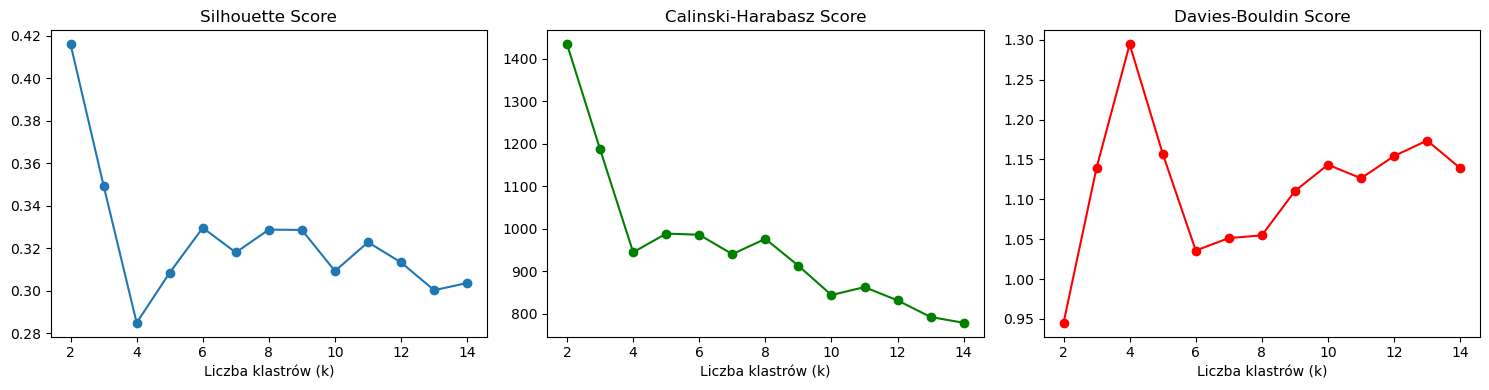

ARI: 0.0803
NMI: 0.0505


In [47]:
best_k = evaluate_kmeans(embedding_clip_umap[:, :-1], k_range=range(2, 15))

# Trening koÅ„cowego modelu
kmeans = KMeans(n_clusters=best_k, random_state=42)
labels_kmeans = kmeans.fit_predict(embedding_clip_umap[:, :-1])

y_encoded = LabelEncoder().fit_transform(embedding_df_clip_scaled[:, -1])

ari = adjusted_rand_score(y_encoded, labels_kmeans)
nmi = normalized_mutual_info_score(y_encoded, labels_kmeans)

print(f"ARI: {ari:.4f}")
print(f"NMI: {nmi:.4f}")

ðŸ”¹ Najlepsze k wg Silhouette Score: 3
ðŸ”¹ Najlepsze k wg Calinski-Harabasz: 3
ðŸ”¹ Najlepsze k wg Davies-Bouldin: 3


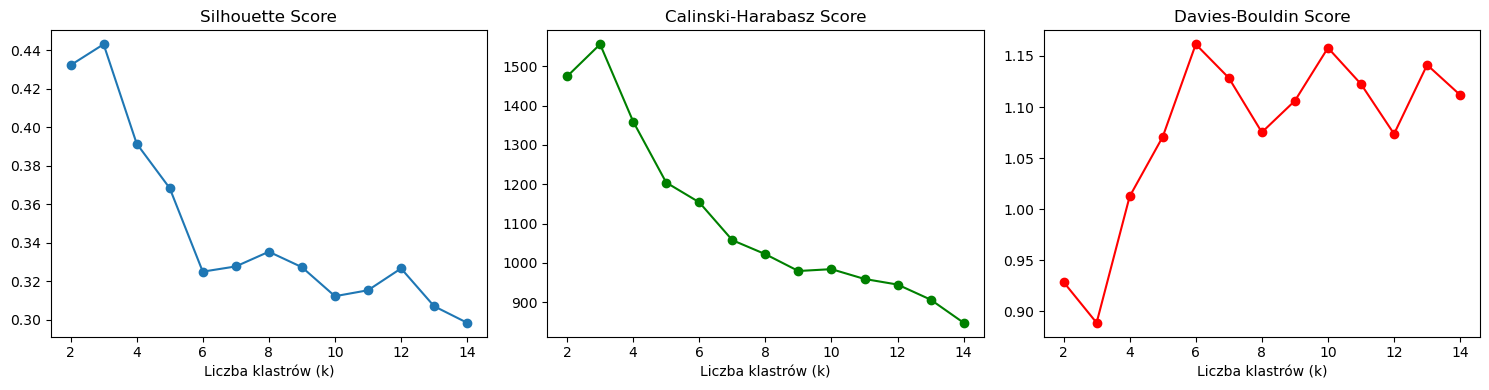

ARI: 0.3176
NMI: 0.3319


In [48]:
best_k = evaluate_kmeans(embedding_resnet_umap[:, :-1], k_range=range(2, 15))

# Trening koÅ„cowego modelu
kmeans = KMeans(n_clusters=best_k, random_state=42)
labels_kmeans = kmeans.fit_predict(embedding_resnet_umap[:, :-1])

y_encoded = LabelEncoder().fit_transform(embedding_df_resnet_scaled[:, -1])

ari = adjusted_rand_score(y_encoded, labels_kmeans)
nmi = normalized_mutual_info_score(y_encoded, labels_kmeans)

print(f"ARI: {ari:.4f}")
print(f"NMI: {nmi:.4f}")